Today, we will continue working on the inverted pendulum environment. However, the goal of this lab will be to implement one of the RL agents discussed in this week's lecture. Don't forget to download the new version of the environment under course contents. In the rest of this notebook, a Chainer skeleton code (with missing functionality) for the reinforce agent is provided. You can either work on finalizing the implementation of the reinforce agent or implement a different model of your choice.

In [1]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from chainer import Chain
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer import Variable
import random
import socket
import struct
import gym
import random

%matplotlib inline

In [2]:
class AIGymEnv:
    def __init__(self):
        self.env = gym.make('CartPole-v1') 
    
    def reset(self):
        observation = self.env.reset()
        return 0, observation, [0]
    
    
    def step(self, action, draw=False):
        if draw:
            self.env.render()
            
        observation, reward, done, info = self.env.step(action)
        
        if done:
            status = [1]
        else:
            status = [0]
        
        return reward, state, status
    

In [3]:
# same environment as last week

class Environment:
    def __init__(self, ip = "127.0.0.1", port = 13000):
        self.client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.ip     = ip
        self.port   = port

        self.client.connect((ip, port))

    def reset(self):
        self._send(0, 0)
        return self._receive()

    def step(self, action):
        self._send(action, 1)
        return self._receive()

    def _receive(self):
        data = self.client.recv(19)
        reward = data[0]
        state = [struct.unpack("@f", data[1 + i * 4: 5 + i * 4])[0] for i in range(4)]
        status = [data[17], data[18]]
        return reward, state, status

    def _send(self, action, command):
        self.client.send(bytes([action, command]))

In [4]:
# Let's define a baseline agent which just emits random actions.


class RandomAgent:
    def __init__(self):
        pass

    def step(self, reward, state):
        return random.randint(0, 1)

Let's run the agent within the environment. (don't forget to start the environment)
if you want to see the agent, also don't forget to enable the camera in the GUI

In [5]:
episode_count = 1000

agent = RandomAgent()
environment = AIGymEnv()

In [6]:
R0 = np.zeros(episode_count)

for i in range(episode_count):
    reward, state, status = environment.reset()

    while (status[0] == 0):
        action = agent.step(reward, state)
        reward, state, status = environment.step(action)
        R0[i] += reward

In [7]:
# Let's create the REINFORCE agent. We assume that the policy is computed using an MLP with a softmax output.

class MLP(Chain):
    """Multilayer perceptron"""

    def __init__(self, n_output=1, n_hidden=5):
        super(MLP, self).__init__(l1=L.Linear(None, n_hidden), l2=L.Linear(n_hidden, n_output))

    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [8]:
# A skeleton for the REINFORCEAgent is given. Implement the compute_loss and compute_score functions.

class REINFORCEAgent(object):
    """Agent trained using REINFORCE"""

    def __init__(self, model, optimizer=Adam()):
        self.model = model

        self.optimizer = optimizer
        self.optimizer.setup(self.model)

        # monitor score and reward
        self.rewards = []
        self.scores = []


    def step(self, reward, state):

        # linear outputs reflecting the log action probabilities and the value
        policy = self.model(Variable(np.atleast_2d(np.asarray(state, 'float32'))))

        # generate action according to policy
        p = F.softmax(policy).data

        # normalize p in case tiny floating precision problems occur
        row_sums = p.sum(axis=1)
        p /= row_sums[:, np.newaxis]

        action = np.asarray([np.random.choice(p.shape[1], None, True, p[0])])

        return action, policy
    

    def compute_loss(self):
        """
        Return loss for this episode based on computed scores and accumulated rewards
        """
    
        # cost to go
        Qhat = 0

        loss = 0
        for t in range(len(self.rewards) - 1, -1, -1):

            Qhat = self.rewards.pop() + Qhat

            _ss = F.squeeze(self.scores.pop(), axis=1) * Qhat

            if _ss.size > 1:
                _ss = F.sum(_ss, axis=0)
            loss += F.squeeze(_ss)

        return loss


    def compute_score(self, action, policy):
        """
        Computes score

        Args:
            action (int):
            policy:

        Returns:
            score
        """

        logp = F.log_softmax(policy)
    
        score = F.select_item(logp, Variable(action))

        # handle case where we have only one element per batch
        if score.ndim == 1:
            score = F.expand_dims(score, axis=1)

        return score

In [9]:
# Now we run the REINFORCE agent within the environment. Note that we update the agent after each episode for simplicity.
# First, we should restart the server from the GUI

environment = AIGymEnv()
network = MLP(n_output=2, n_hidden=3)
agent = REINFORCEAgent(network, optimizer=Adam())
    
R = np.zeros(episode_count)


In [10]:
for i in tqdm.trange(episode_count):

    reward, state, status = environment.reset()

    loss = 0
    while True:

        action, policy = agent.step(reward, state)

        reward, state, status = environment.step(action[0])

        # get reward associated with taking the previous action in the previous state
        agent.rewards.append(reward)
        R[i] += reward

        # recompute score function: grad_theta log pi_theta (s_t, a_t) * v_t
        agent.scores.append(agent.compute_score(action, policy))

        # we learn at the end of each episode
        if status[0] == 1:
            
            loss += agent.compute_loss()
            
            agent.model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            agent.optimizer.update()

            break

100%|██████████| 1000/1000 [00:59<00:00, 16.76it/s]


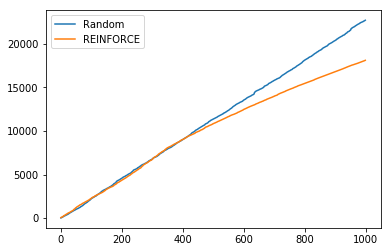

In [11]:
# and we finally plot the accumulated reward per episode

plt.figure()
plt.plot(np.cumsum(R0))
plt.plot(np.cumsum(R))
plt.legend(['Random', 'REINFORCE'])
plt.show()

In [15]:
# A skeleton for the DQNAgent is given. Implement the compute_loss and compute_score functions.

class DQNAgent(object):
    """Agent trained using DQN"""

    def __init__(self, qnet, qhatnet, optimizer=Adam()):
        self.qnet = qnet
        self.qhatnet = qhatnet

        self.optimizer = optimizer
        self.optimizer.setup(self.qnet)
        
        self.epsilon = 1
        self.bufsize = 1000
        
        # shape (state, action, reward, new_state)
        self.buffer = []


    def step(self, reward, state):

        
        # "toss a coin" to decide whether to take a random action
        coin = np.random.rand()
        
        # if random action
        if coin <= self.epsilon:
            return random.randint(0, 1)
        
        # linear outputs reflecting the log action probabilities and the value
        Qvals = self.qhatnet(Variable(np.atleast_2d(np.asarray(state, 'float32')))).data
        maxQ = np.amax(Qvals)
        action = np.where(Qvals == maxQ)[0][0]
        return action 
    

    def compute_loss(self):
        """
        Return loss for this episode based on computed scores and accumulated rewards
        """
    
        # cost to go
        Qhat = 0

        loss = 0
        for t in range(len(self.rewards) - 1, -1, -1):

            Qhat = self.rewards.pop() + Qhat

            _ss = F.squeeze(self.scores.pop(), axis=1) * Qhat

            if _ss.size > 1:
                _ss = F.sum(_ss, axis=0)
            loss += F.squeeze(_ss)

        return loss


    def compute_score(self, action, policy):
        """
        Computes score

        Args:
            action (int):
            policy:

        Returns:
            score
        """

        logp = F.log_softmax(policy)
    
        score = F.select_item(logp, Variable(action))

        # handle case where we have only one element per batch
        if score.ndim == 1:
            score = F.expand_dims(score, axis=1)

        return score

In [13]:
# Now we run the DQN agent within the environment. Note that we update the agent after each episode for simplicity.
# First, we should restart the server from the GUI

environment = AIGymEnv()

qnet = MLP(n_output=2, n_hidden=3)
qhatnet = MLP(n_output=2, n_hidden=3)

agent = DQNAgent(qnet, qhatnet, optimizer=Adam())
    
R_DQN = np.zeros(episode_count)


In [14]:
minibatch_size = 100

for i in tqdm.trange(episode_count):

    reward, state, status = environment.reset()

    iteration = 0
    while True:
        buffer = []
        action = agent.step(reward, state)
        reward, new_state, status = environment.step(action)

        # get reward associated with taking the previous action in the previous state
        R[i] += reward
        
        observation = (state, action, reward, new_state)
        buffer.append(observation)
        
        # we learn at the end of each episode
        if status[0] == 1:     
            agent.buffer += buffer
            print("First Element in Buffer: ", agent.buffer[0])
            break
            replaysize = len(agent.buffer)
            
            # only start learning when buffer is full
            # discard oldest observations
            if replaysize >= agent.bufsize:
                agent.epsilon = .3 # no longer exclusively take random actions
                agent.buffer = agent.buffer[-1000:]
                
                # sample minibatch
                indices = random.sample(range(len(agent.buffer)), minibatch_size)
                batch = [agent.buffer[i] for i in indices]

                # iterate over batch and calculate loss
                loss = 0.0
                for b in batch:
                    state, action, reward, new_state = b
                    qvals = agent.qnet(Variable(state))
                    qval  = F.select_item(qvals, action)
                    
                    if reward == 0:
                        y = 0
                    
                    else:
                        # calculate qhat_max
                        qvals = agent.qhatnet(Variable(new_state))
                        qhat_max = F.max(Qvals)
                        y = reward + qhat_max
                    
                    loss += F.squeeze(F.square(qval - y))
                    
            
            # learn based on experience, update qnet
            agent.qnet.cleargrads()
            loss.backward()
            loss.unchain_backward()
            agent.optimizer.update()
            iteration +=1
            
            # every 20 episodes update target network
            if iteration % 20 == 0:
                pass
            
            break

  8%|▊         | 78/1000 [00:00<00:02, 387.42it/s]

First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317

 15%|█▌        | 154/1000 [00:00<00:02, 377.32it/s]

 (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.0262023

 25%|██▌       | 250/1000 [00:00<00:01, 423.81it/s]


First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.0094231

 34%|███▍      | 344/1000 [00:00<00:01, 446.09it/s]

 (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.0262023

 45%|████▌     | 451/1000 [00:01<00:01, 487.64it/s]

 (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.0262023

 56%|█████▌    | 561/1000 [00:01<00:00, 515.41it/s]

 (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.0262023

 67%|██████▋   | 668/1000 [00:01<00:00, 501.02it/s]

 (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.0262023

 78%|███████▊  | 785/1000 [00:01<00:00, 538.98it/s]


First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.0094231

 90%|█████████ | 905/1000 [00:01<00:00, 565.14it/s]

First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317

100%|██████████| 1000/1000 [00:02<00:00, 491.32it/s]

 (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]), 1, 1.0, array([ 0.03501647, -0.00942317,  0.01342997,  0.02620235]))
First Element in Buffer:  (array([ 0.03501647, -0.00942317,  0.01342997,  0.0262023